# Solving free vibration using PINNs
Considering: M = 1 kg , C = 1 N.s/m , K = 1 N/m 

In [260]:
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
import torch
import torch.nn as nn
import time as timelib

In [261]:
device = torch.device(0)

In [262]:
st = timelib.time()

In [263]:
def exact_sol(t):
    o = 0.5*torch.exp(-t/2)*(torch.sin(torch.sqrt(torch.tensor(3))*t/2)/torch.sqrt(torch.tensor(3)) + torch.cos(torch.sqrt(torch.tensor(3))*t/2))
    return o

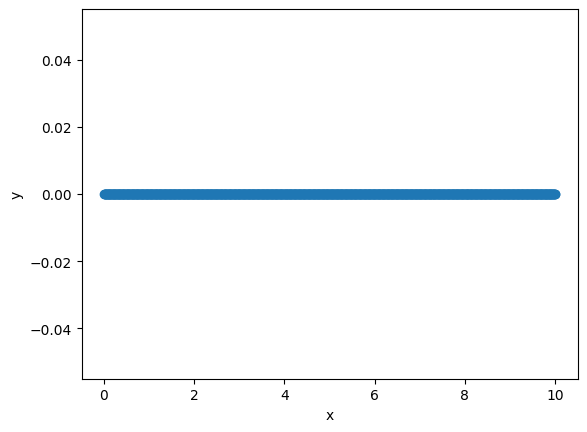

Generated 1000 samples with LHS.


In [264]:
# Define the domain intervals for each dimension
xlimits = np.array([[0.0, 10.0],[0.0,0.0]])

# Create an LHS sampling instance
sampling = LHS(xlimits=xlimits)

# Generate 10000 samples
num_samples = 1000
samples = sampling(num_samples)

# Visualize the samples
plt.plot(samples[:, 0],samples[:,1], "o")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f"Generated {num_samples} samples with LHS.")
# t = np.linspace(0,1,100)

# x = np.ones_like(t) * 0.0
x = samples[:, 0]
x = torch.from_numpy(x)
x = x.float().to(device)
x.requires_grad = True

x_init = torch.tensor(0.0,dtype=torch.float32,requires_grad=True).to(device)
y_init = torch.tensor(0.5,dtype=torch.float32,requires_grad=True).to(device)
dy_init = torch.tensor(0.0,dtype=torch.float32,requires_grad=True).to(device)

In [265]:
class PINN(nn.Module):
    def __init__(self,layers) -> None:
        super(PINN,self).__init__()
        self

        self.x = x
        self.x_init = x_init
        self.y_init = y_init
        self.dy_init = dy_init

        self.loss_rec = []

        self.layers = layers
        self.net = nn.Sequential()
        for i in range(len(layers) - 2):
            self.net.add_module(f'layer_{i}', nn.Linear(layers[i], layers[i+1]))
            self.net.add_module(f'activation_{i}', nn.Tanh())
            # self.net.add_module(f'dropout_{i}', nn.Dropout(p=self.dropout_prob))  # Add dropout
            # self.net.add_module(f'batchnorm_{i}', nn.BatchNorm1d(layers[i+1])) # Add batchnorm
        self.net.add_module('output', nn.Linear(layers[-2], layers[-1]))
        self.net.add_module(f'activation_output', nn.Tanh())

        self.adam = torch.optim.Adam(self.net.parameters(),lr=5e-3)
        self.lbfgs = torch.optim.LBFGS(
                                        self.net.parameters(),
                                        lr=1,
                                        max_iter=2000,
                                        max_eval=2000,
                                        tolerance_grad=0,
                                        tolerance_change=0,
                                        history_size=500,
                                        line_search_fn="strong_wolfe",
                                       )
    def forward(self,x):
        u = self.net(x.view(-1,1))
        return u[:, 0]
    
    def ODE_loss(self):
        y = self.forward(self.x)
        dy = torch.autograd.grad(y.sum(),self.x , create_graph=True)[0]
        d2y = torch.autograd.grad(dy.sum(),self.x, create_graph=True)[0]
        return torch.mean(torch.square(d2y + dy + y))
    
    def boundary_loss(self):
        y = self.forward(self.x_init)
        dy = torch.autograd.grad(y.sum(),self.x_init , create_graph=True)[0]
       
        return torch.mean(torch.square(y-self.y_init)) + torch.mean(torch.square(dy-self.dy_init))
    
    def closure(self):
        self.adam.zero_grad()
        self.lbfgs.zero_grad()

        loss = self.boundary_loss() + self.ODE_loss()
        self.loss_rec.append(loss.detach().cpu().item())

        print(f"\r epoch {len(self.loss_rec)} , loss : {loss.detach().cpu().item():5e} , time : {timelib.time()-st:.2f} s",end="",)
        if len(self.loss_rec)%100 ==0:
            print("")

        loss.backward()

        return loss
    
    def train(self,optimizer,epoch):
        try:
            c = 0
            for i in optimizer:
                for j in range(epoch[c]):
                    if i == self.adam:
                        ls = self.closure()
                        i.step()
                    else:
                        i.step(self.closure)
                
                c+=1
        except KeyboardInterrupt:
            print("")
            print("intrrupted by user")

    def plot(self):
        with torch.no_grad():
            plt.figure(figsize=(5,2.5))
            plt.semilogy(range(len(self.loss_rec)),self.loss_rec)
            plt.ylim([0, max(self.loss_rec)])
            plt.xlim([0,len(self.loss_rec)])
            plt.ylabel('Loss')
            plt.xlabel('Epoch')



In [266]:
ode_solver = PINN([1,8,8,8,1]).to(device)
optimizer = [ode_solver.adam,ode_solver.lbfgs]
epoch = [100,200]

In [267]:
ode_solver.train(optimizer,epoch)

 epoch 4 , loss : 7.044448e-02 , time : 0.43 s

 epoch 100 , loss : 2.703432e-03 , time : 1.79 s
 epoch 200 , loss : 1.389268e-04 , time : 5.43 s
 epoch 300 , loss : 5.778480e-06 , time : 11.48 s
 epoch 400 , loss : 5.144862e-06 , time : 19.77 s
 epoch 500 , loss : 4.053850e-06 , time : 30.06 s
 epoch 600 , loss : 3.249235e-06 , time : 42.91 s
 epoch 700 , loss : 2.205986e-06 , time : 58.44 s
 epoch 800 , loss : 1.868511e-06 , time : 76.20 s
 epoch 900 , loss : 7.265792e-07 , time : 91.74 s
 epoch 1000 , loss : 8.092771e-08 , time : 108.84 s
 epoch 1100 , loss : 7.536986e-08 , time : 124.06 s
 epoch 1200 , loss : 7.453954e-08 , time : 142.71 s
 epoch 1300 , loss : 6.187049e-08 , time : 158.65 s
 epoch 1400 , loss : 6.167954e-08 , time : 169.14 s
 epoch 1500 , loss : 6.168163e-08 , time : 173.85 s
 epoch 1600 , loss : 6.167964e-08 , time : 179.01 s
 epoch 1700 , loss : 6.167954e-08 , time : 184.13 s
 epoch 1800 , loss : 6.168163e-08 , time : 189.05 s
 epoch 1900 , loss : 6.167964e-08 , time : 194.62 s
 epoch 1929 , loss : 6.167954e-0

C:\Users\mobit\AppData\Local\Temp\ipykernel_37656\4001353402.py:85: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, max(self.loss_rec)])


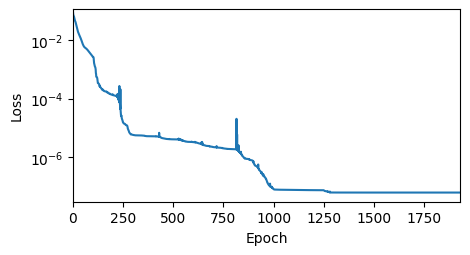

In [268]:
ode_solver.plot()

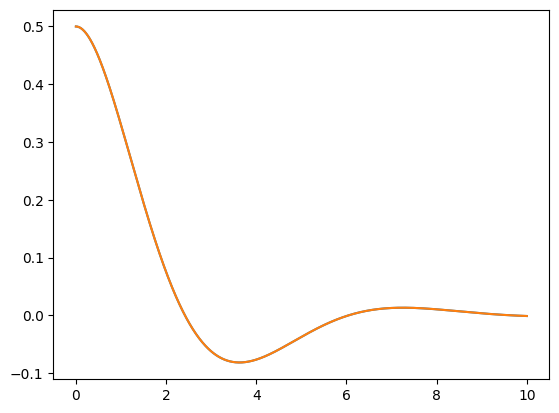

In [269]:
l = torch.linspace(0,10,1000).to(device)
y = ode_solver(l)
y_ex = exact_sol(l)
plt.plot(l.detach().cpu().numpy(),y.detach().cpu().numpy())
plt.plot(l.detach().cpu().numpy(),y_ex.detach().cpu().numpy())